In [5]:
#importing libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
ds = pd.read_csv("./Data/train.csv")
ds.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
ds.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
ds = ds.dropna()
ds.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
#after dropping null values,indexes will be unordered therfore resetting indexes
ds.reset_index(inplace = True,drop = True)
ds.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
#defining dependent and independent vectors
#taking only title for prediction
x = ds.iloc[:,1:2]
y = ds['label']

In [11]:
x.head()

,title
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...


<Axes: xlabel='label', ylabel='count'>

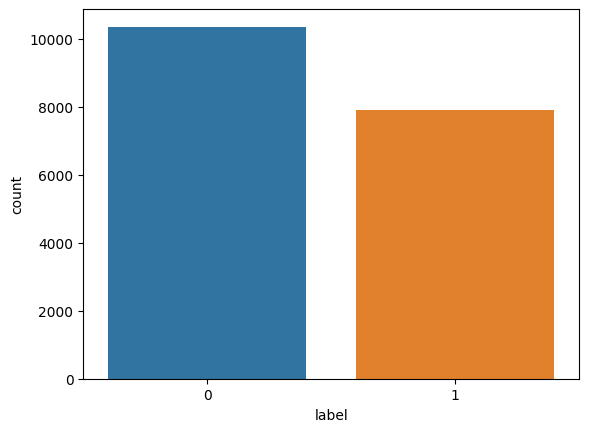

In [12]:
#checking number of real and fake news
sns.countplot(x = 'label',data = ds)

In [13]:
#Text Cleaning and preprocessing

cleaned = []
for i in range(0,len(ds)):
    
    #removing words any other than (a-z) and (A-Z)
    text = re.sub('[^a-zA-Z]',' ', x['title'][i])
    
    #converting all words into lower case
    text = text.lower()
    
    #tokenizing 
    text = text.split()
    
    #stemming and removing stopwords
    ps = PorterStemmer()
    text = [ps.stem(words) for words in text if words not in stopwords.words('english')]
    text = ' '.join(text)
    cleaned.append(text)

In [14]:
#cleaned text
cleaned[:5]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [15]:
#taking dictionary size 5000
vocab_size = 5000

#one hot encoding
one_hot_dir = [one_hot(words,vocab_size) for words in cleaned]

#length of all rows should be equal therefore applying padding
#this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

array([[   0,    0,    0, ...,  301, 4599, 1463],
       [   0,    0,    0, ..., 4896, 3649, 3729],
       [   0,    0,    0, ..., 4303, 3960, 3855],
       ...,
       [   0,    0,    0, ..., 1792, 1229, 1464],
       [   0,    0,    0, ..., 2148, 2702, 4287],
       [   0,    0,    0, ..., 1687, 4359, 1671]])

In [16]:
#converting into numpy arrays.
x = np.array(embedded_layer)
y = np.array(y)

In [17]:
#splitting the Dataset into Train and Test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [18]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(vocab_size,50,input_length = len(embedded_layer[0])))
model.add(Dropout(0.5))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))
model.add(Dropout(0.5))

#adding output layer 
model.add(Dense(1,activation="sigmoid"))

#compiling the model
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [19]:
#summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 50)            250000    
                                                                 
 dropout (Dropout)           (None, 47, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________


In [20]:
#training the model
model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 5, batch_size = 32)

Epoch 1/5
458/458 [==============================] - 11s 21ms/step - loss: 0.2725 - accuracy: 0.8741 - val_loss: 0.1821 - val_accuracy: 0.9243
Epoch 2/5
458/458 [==============================] - 10s 21ms/step - loss: 0.1523 - accuracy: 0.9403 - val_loss: 0.1720 - val_accuracy: 0.9281
Epoch 3/5
458/458 [==============================] - 10s 21ms/step - loss: 0.1164 - accuracy: 0.9563 - val_loss: 0.2053 - val_accuracy: 0.9308
Epoch 4/5
458/458 [==============================] - 10s 23ms/step - loss: 0.0959 - accuracy: 0.9645 - val_loss: 0.2076 - val_accuracy: 0.9297
Epoch 5/5
458/458 [==============================] - 10s 22ms/step - loss: 0.0733 - accuracy: 0.9735 - val_loss: 0.2060 - val_accuracy: 0.9305


In [21]:
#predicting and getting accuracy
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

115/115 [==============================] - 1s 8ms/step


0.9305441618813235

<Axes: >

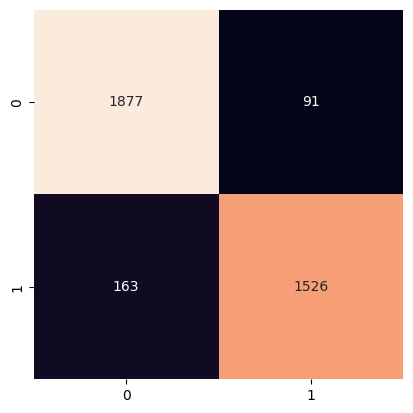

In [24]:
#getting confusion matrix
from sklearn.metrics import confusion_matrix
cmax=confusion_matrix(y_test,y_pred)
sns.heatmap(cmax.T, square=True, annot=True, fmt='d', cbar=False)